In [7]:
from pandas import DataFrame, Series, read_csv

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [46]:
os.chdir("/home/pablosm/Escritorio/LCG/2026-1/H_contortus_Transcriptomics")

def get_label(df: DataFrame, name_col: str = "gene_name") -> Series:
    return df[name_col].astype(str) if name_col and name_col in df.columns else df.index.astype(str)

def annotate_top_genes(ax, stats: DataFrame, n: int = 20, name_col: str = "") -> None:
    up = stats[stats["Expression"] == "UP"].copy()
    down = stats[stats["Expression"] == "DOWN"].copy()

    up = up.sort_values(["padj", "log2FoldChange"], ascending=[True, False]).head(n)
    down = down.sort_values(["padj", "log2FoldChange"], ascending=[True, True]).head(n)

    up_labels = get_label(df=up, name_col=name_col)
    down_labels = get_label(df=down, name_col=name_col)
    batches = [(up, up_labels, 0.12, 0.06, "left"),(down, down_labels, -0.12, 0.06, "right")]

    for df, df_labels, dx, dy, ha in batches:
        for (gene, row), label in zip(df.iterrows(), df_labels):
            x, y = row["log2FoldChange"], row["log10Neg"]
            ax.annotate(
                label,
                xy=(x, y),
                xytext=(x + dx, y + dy),
                textcoords='data',
                arrowprops=dict(arrowstyle='-',lw=0.4,alpha=0.5),
                fontsize=7,
                ha=ha,
                va="center"
            )

def mapper(
    A: DataFrame,
    B: DataFrame,
    *,
    A_id_col: str = "",
    B_id_col: str = "",
    B_symbol_col: str = "symbol",
    out_col: str = "symbol",
    change_index: bool = False,
    inplace: bool = True,
    keep: str = "first"
) -> DataFrame | None:
    """
    Maps gene identifiers from DataFrame A to gene symbols from DataFrame B.

    This function allows flexible merging/matching of gene IDs and their 
    associated gene symbols. It supports cases where IDs appear either in
    the index or in a specific column in both A and B. The resulting mapping
    can either be added as a new column in A or used to replace its index.

    Parameters
    ----------
    A : pandas.DataFrame
        DataFrame whose gene IDs are to be mapped.

    B : pandas.DataFrame
        DataFrame containing gene IDs and their associated gene symbols.

    A_id_col : str, default ""
        Column in A containing gene IDs.  
        If empty (""), the index of A is assumed to contain the IDs.

    B_id_col : str, default ""
        Column in B containing gene IDs.  
        If empty (""), the index of B is assumed to contain the IDs.

    B_symbol_col : str, default "symbol"
        Column in B containing the gene symbols to map onto A.

    out_col : str, default "symbol"
        Name of the output column created in A when `change_index=False`.

    change_index : bool, default False
        If True, the index of A will be replaced by the mapped symbols
        (or the original ID when no match is found).
        If False, a new column containing the mapped values will be added.

    inplace : bool, default True
        If True, modifies A in place and returns None.
        If False, returns a modified copy of A.

    keep : {"first","last"}, default "first"
        Which duplicate to keep in B when multiple symbols exist
        for the same ID.

    Returns
    -------
    pandas.DataFrame or None
        - If `inplace=False`, returns the modified DataFrame.
        - If `inplace=True`, returns None.

    Notes
    -----
    - Any ID in A that does not exist in B will retain its original value
      (either as index or in the output column).
    - Both A and B may contain IDs as index or as a column; this function
      generalizes gracefully to both layouts.

    """
    if not inplace:
        A = A.copy()

    if A_id_col:
        A_ids = A[A_id_col].astype(str)
    else:
        A_ids = Series(A.index.astype(str), index=A.index)

    if B_id_col:
        tmp = B[[B_id_col, B_symbol_col]].copy()
        tmp[B_id_col] = tmp[B_id_col].astype(str)
        tmp[B_symbol_col] = tmp[B_symbol_col].astype(str)
        if tmp[B_id_col].duplicated().any():
            ndup = tmp[B_id_col].duplicated().sum()
            # lg.warning(f"[MAPPER] B has {ndup} duplicated IDs in '{B_id_col}'. Keeping {keep}.")
        tmp = tmp.drop_duplicates(subset=B_id_col, keep=keep)
        B_map = tmp.set_index(B_id_col)[B_symbol_col]
    else:
        tmp = B[[B_symbol_col]].copy()
        tmp.index = tmp.index.astype(str)
        tmp[B_symbol_col] = tmp[B_symbol_col].astype(str)
        if tmp.index.duplicated().any():
            ndup = tmp.index.duplicated().sum()
            # lg.warning(f"[MAPPER] B has {ndup} duplicated index IDs. Keeping {keep}.")
        tmp = tmp[~tmp.index.duplicated(keep=keep)]
        B_map = tmp[B_symbol_col]

    mapped = Series(A_ids.map(B_map), index=A_ids.index)
    mapped = mapped.fillna(A_ids)

    if change_index:
        A.index = mapped.values
        A.index.name = None
    else:
        A[out_col] = mapped

    return None if inplace else A

def volcano_plot(
    stats: DataFrame,
    lfc_criteria: int = 1,
    padj_criteria: float = 1e-2,
    gene_col_name: str = "gene_name",
    top_genes: int = 0,
    svfig: bool = False,
    filename: str = "genes_classification",
    outdir: str = "results/",
    outfmt: str = "jpg,svg",
    color_palette: str = "Spectral",
    dpi: int = 300
) -> None:
    valid_formats = {"png", "pdf", "svg", "eps", "ps", "jpg", "jpeg"}
    cmap = sns.color_palette(color_palette, as_cmap=True)
    log10_criteria = -np.log10(padj_criteria)
    order = ["NON-DE", "DOWN", "UP"]
    colors = {"UP" : cmap(1.0), "NON-DE" : (0.75, 0.75, 0.75, 0.3), "DOWN" : cmap(0.0)}
    fig, ax = plt.subplots(figsize=(10, 6))

    sns.scatterplot(
        data=stats,
        x="log2FoldChange",
        y="log10Neg",
        hue="Expression",
        hue_order=order,
        palette=colors,
        s=20,
        ax=ax
    )

    ax.set_xlabel("log2(Fold Change)")
    ax.set_ylabel("-log10(padj)")
    ax.set_title("Volcano Plot")
    ax.grid(True, alpha=0.5, linestyle="--")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.axvline(lfc_criteria,  color='gray', linestyle='--', alpha=0.7)
    ax.axvline(-lfc_criteria, color='gray', linestyle='--', alpha=0.7)
    ax.axhline(log10_criteria, color='gray', linestyle='--', alpha=0.7)

    if top_genes:
        annotate_top_genes(ax=ax,stats=stats,n=top_genes,name_col=gene_col_name)

    fig.tight_layout()

    if svfig:
        try:
            formats = set()
            if (fmt := filename.split(".")[-1].strip()) and fmt in valid_formats:
                formats.add(fmt)
            if (fmt := outfmt.split(",")):
                formats.update(e for f in fmt if (e:=f.strip()) in valid_formats)

        except Exception as e:
            msg = "[VOLCANO] The saving format couldn't be applied"
            raise ValueError(msg)
            
        for fmt in formats:
            fname, _ = os.path.splitext(os.path.basename(filename))
            plt.savefig(f'{outdir}/{fname}.{fmt}', dpi=dpi, bbox_inches='tight')

    else:
        plt.show()
        print("[VOLCANO] The plot was displayed in the user stout but not saved")

    plt.close(fig=fig)

    return

def heatmap(
        data: DataFrame,
        zscore: int = 0,
        svfig: bool = False,
        filename: str = "genes_classification",
        outdir: str = "results/",
        outfmt: str = "jpg,svg",
        color_palette: str = "Spectral",
        dpi: int = 300
) -> None:
    valid_formats = {"png", "pdf", "svg", "eps", "ps", "jpg", "jpeg"}
    cmap = sns.color_palette(color_palette, as_cmap=True)

    cg = sns.clustermap(
        data,
        cmap=cmap,
        z_score=zscore,
        row_cluster=True,
        col_cluster=True,
        figsize=(10, 8),
        center=0
    )

    cg.figure.suptitle("Heatmap of Differentially Expressed Genes", y=1.02)
    cg.cax.set_ylabel(
        "Z-score (log1p counts)\n(Down  ←   →  Up)",
        rotation=90,
        ha="center",
        va="center",
        labelpad=12
    )
    cg.figure.tight_layout()
    cg.figure.subplots_adjust(top=0.95)

    if svfig:
        try:
            formats = set()
            if (fmt := filename.split(".")[-1].strip()) and fmt in valid_formats:
                formats.add(fmt)
            if (fmt := outfmt.split(",")):
                formats.update(e for f in fmt if (e:=f.strip()) in valid_formats)

        except Exception as e:
            msg = "[HEATMAP] The saving format couldn't be applied"
            raise ValueError(msg)
            
        for fmt in formats:
            fname, _ = os.path.splitext(os.path.basename(filename))
            cg.figure.savefig(f"{outdir}/{fname}.{fmt}", dpi=dpi, bbox_inches="tight")

    else:
        plt.show()
        print("[HEATMAP] The plot was displayed in the user stout but not saved")

    plt.close(cg.figure)

    return

def get_count_mtx(count_path: str, sep: str = "\t", index_col: int = 0) -> DataFrame:
    if not os.path.isfile(count_path):
        msg = f"[GET] File {os.path.basename(count_path)} not available at {os.path.dirname(count_path)}"
        raise ValueError(msg)

    count = read_csv(count_path, sep=sep, index_col=index_col, engine="python")
    if count.index.name:
        count.index.name = None
    
    return count

In [28]:
dea_clean = "results/diffexp_matrix_no_annot_lfc1.tsv"
ko_terms = "results/gene_id_to_gene_name.tsv"
norm = "results/normcounts.tsv"
stast = get_count_mtx(dea_clean, sep="\t", index_col=0); display(stast)
ko = get_count_mtx(ko_terms, sep="\t", index_col=0); display(ko)
ncounts = get_count_mtx(norm, sep="\t", index_col=0); display(ncounts)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Expression,log10Neg
TRINITY_DN21697_c0_g1_i1,39.737441,-0.093918,0.985386,-0.095310,9.240683e-01,1.000000e+00,NON-DE,2.118247e-08
TRINITY_DN21697_c0_g2_i1,37.524303,0.024821,0.595883,0.041654,9.667742e-01,1.000000e+00,NON-DE,2.118247e-08
TRINITY_DN21663_c0_g1_i4,18.082000,0.255466,1.781106,0.143431,8.859499e-01,1.000000e+00,NON-DE,2.118247e-08
TRINITY_DN21663_c0_g1_i5,45.532269,-0.016348,0.657552,-0.024861,9.801657e-01,1.000000e+00,NON-DE,2.118247e-08
TRINITY_DN21691_c0_g1_i1,45.101263,-0.010594,0.814811,-0.013002,9.896261e-01,1.000000e+00,NON-DE,2.118247e-08
...,...,...,...,...,...,...,...,...
TRINITY_DN43355_c0_g1_i3,30.681805,0.039892,0.605551,0.065877,9.474758e-01,1.000000e+00,NON-DE,2.118247e-08
TRINITY_DN43311_c0_g1_i2,40.362311,-0.087245,0.635023,-0.137389,8.907233e-01,1.000000e+00,NON-DE,2.118247e-08
TRINITY_DN43311_c0_g1_i3,413.588500,-12.343513,1.984767,-6.219124,4.999393e-10,3.157640e-07,DOWN,6.500637e+00
TRINITY_DN43337_c0_g1_i2,75.841066,-0.059229,0.682424,-0.086792,9.308372e-01,1.000000e+00,NON-DE,2.118247e-08


,KO,gene_name,gene_symbol
TRINITY_DN3888_c0_g1_i3,K00234,succinate dehydrogenase (ubiquinone) flavoprot...,SDHA
TRINITY_DN56787_c0_g1_i5,K03231,elongation factor 1-alpha,EEF1A1
TRINITY_DN5967_c0_g1_i5,K01415,endothelin-converting enzyme [EC:3.4.24.71],EEF1AKMT4-ECE2
TRINITY_DN17224_c0_g1_i7,K00025,malate dehydrogenase [EC:1.1.1.37],MDH1
TRINITY_DN17224_c0_g1_i8,K00025,malate dehydrogenase [EC:1.1.1.37],MDH1
...,...,...,...
TRINITY_DN2422_c0_g1_i5,K08490,syntaxin 5,STX5
TRINITY_DN2422_c0_g1_i6,K08490,syntaxin 5,STX5
TRINITY_DN2417_c0_g1_i4,K21773,protein lin-9,LIN9
TRINITY_DN2423_c0_g1_i7,K01952,phosphoribosylformylglycinamidine synthase [EC...,PFAS


,TRINITY_DN21697_c0_g1_i1,TRINITY_DN21697_c0_g2_i1,TRINITY_DN21663_c0_g1_i4,TRINITY_DN21663_c0_g1_i5,TRINITY_DN21691_c0_g1_i1,TRINITY_DN21656_c0_g1_i4,TRINITY_DN21656_c0_g1_i5,TRINITY_DN21656_c0_g1_i1,TRINITY_DN21656_c0_g1_i2,TRINITY_DN21656_c0_g1_i3,...,TRINITY_DN43305_c0_g1_i1,TRINITY_DN43309_c0_g1_i5,TRINITY_DN43357_c0_g1_i4,TRINITY_DN43357_c0_g1_i1,TRINITY_DN43355_c0_g1_i2,TRINITY_DN43355_c0_g1_i3,TRINITY_DN43311_c0_g1_i2,TRINITY_DN43311_c0_g1_i3,TRINITY_DN43337_c0_g1_i2,TRINITY_DN43337_c0_g1_i3
Suceptible_1,44.656898,42.366800,21.755925,24.046022,27.481168,44.656898,758.022212,150.001374,64.122725,119.085060,...,298.857700,11.450487,19.465827,67.557871,40.076703,37.786606,53.817287,453.439269,82.443503,49.237092
Suceptible_2,10.228454,24.548291,26.593982,51.142272,79.781945,8.182764,1104.673084,56.256500,46.028045,54.210809,...,172.860881,28.639673,15.342682,46.028045,21.479754,23.525445,20.456909,1115.924384,35.799591,64.439263
Suceptible_3,68.089712,44.610501,1.173961,62.219909,28.175053,9.391684,1211.527289,24.653172,105.656450,204.269136,...,151.440911,11.739606,32.870895,55.176146,41.088619,29.349014,50.480304,912.167349,113.874174,125.613779
Resistant_1,19.507586,50.719724,20.482965,27.310620,31.212138,38.039793,1151.922956,23.409103,58.522758,152.159171,...,221.411102,21.458345,33.162896,77.054965,43.892069,41.941310,34.138276,0.000000,44.867448,55.596620
Resistant_2,21.991524,28.100280,38.485166,51.924431,25.656778,26.878529,922.422239,60.476690,56.811436,51.924431,...,286.500682,8.552259,15.882767,43.372171,22.602399,23.213275,35.430788,0.000000,61.698441,90.409597
Resistant_3,73.950471,34.800222,0.000000,56.550360,78.300499,3.262521,1018.993993,158.776012,100.050638,159.863519,...,119.625762,27.187673,19.575125,56.550360,38.062743,28.275180,47.850305,0.000000,116.363242,79.388006


In [37]:
dea_clean = mapper(stast, ko, A_id_col="", B_id_col="", B_symbol_col="gene_symbol", out_col="gene_symbol", change_index=False, inplace=False)
dea_clean

updown_genes = dea_clean[dea_clean["Expression"].isin(["UP","DOWN"])]

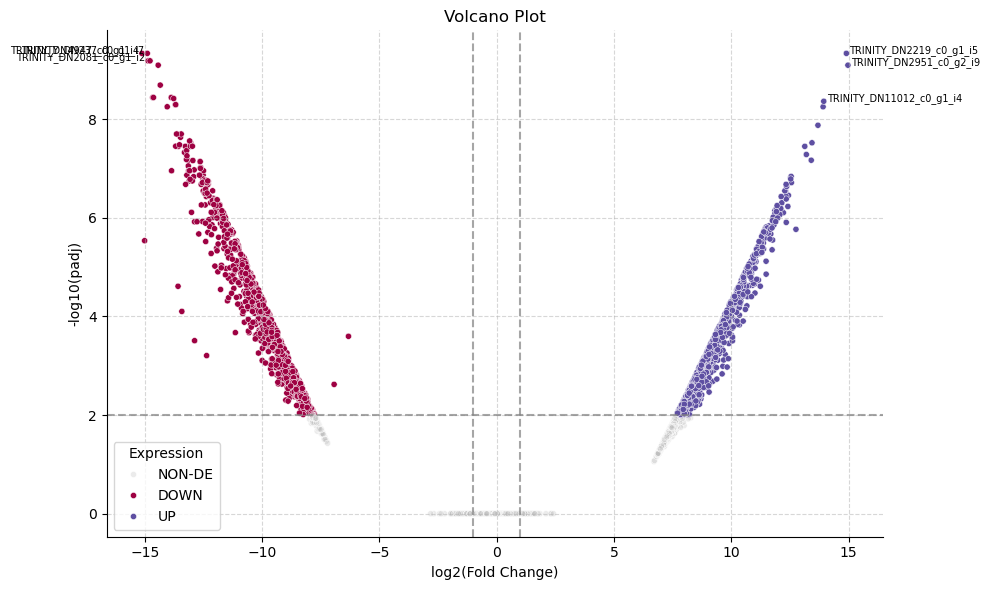

[VOLCANO] The plot was displayed in the user stout but not saved


In [27]:
volcano_plot(
    stats=dea_clean,
    lfc_criteria=1,
    padj_criteria=1e-2,
    gene_col_name="gene_symbol",
    top_genes=3,
    svfig=False,
    # filename=args.volcano_name,
    # outdir=args.outdir,
    # outfmt=args.image_formats,
    # color_palette=args.palette_colors,
    # dpi=args.dpi
)

In [40]:
gene_names = updown_genes.index
heatmap_data = np.log1p(ncounts.loc[:, gene_names]).T
heatmap_data

,Suceptible_1,Suceptible_2,Suceptible_3,Resistant_1,Resistant_2,Resistant_3
TRINITY_DN21634_c0_g1_i5,3.870096,4.047541,4.028492,0.000000,0.000000,0.000000
TRINITY_DN47495_c0_g1_i4,0.000000,0.000000,0.000000,4.118606,3.909421,4.615622
TRINITY_DN60279_c0_g1_i1,4.986487,3.934165,4.764070,0.000000,0.000000,0.000000
TRINITY_DN60273_c0_g2_i4,5.138543,6.122857,6.785579,0.000000,0.000000,0.000000
TRINITY_DN27341_c1_g1_i2,3.795755,3.199711,4.049175,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
TRINITY_DN2407_c0_g1_i7,0.000000,0.000000,0.000000,3.613321,4.880735,4.302212
TRINITY_DN2497_c0_g1_i6,5.718467,4.889951,5.794643,0.000000,0.000000,0.000000
TRINITY_DN2497_c0_g1_i3,5.868378,5.078692,5.644565,0.000000,0.000000,0.000000
TRINITY_DN2497_c0_g1_i9,0.000000,0.000000,0.000000,3.782294,3.489377,4.359436


In [42]:
heatmap_data = mapper(heatmap_data, ko, A_id_col="", B_id_col="", B_symbol_col="gene_symbol", change_index=True, inplace=False)
heatmap_data

,Suceptible_1,Suceptible_2,Suceptible_3,Resistant_1,Resistant_2,Resistant_3
TRINITY_DN21634_c0_g1_i5,3.870096,4.047541,4.028492,0.000000,0.000000,0.000000
TRINITY_DN47495_c0_g1_i4,0.000000,0.000000,0.000000,4.118606,3.909421,4.615622
TRINITY_DN60279_c0_g1_i1,4.986487,3.934165,4.764070,0.000000,0.000000,0.000000
TRINITY_DN60273_c0_g2_i4,5.138543,6.122857,6.785579,0.000000,0.000000,0.000000
TRINITY_DN27341_c1_g1_i2,3.795755,3.199711,4.049175,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
TRINITY_DN2407_c0_g1_i7,0.000000,0.000000,0.000000,3.613321,4.880735,4.302212
TRINITY_DN2497_c0_g1_i6,5.718467,4.889951,5.794643,0.000000,0.000000,0.000000
TRINITY_DN2497_c0_g1_i3,5.868378,5.078692,5.644565,0.000000,0.000000,0.000000
TRINITY_DN2497_c0_g1_i9,0.000000,0.000000,0.000000,3.782294,3.489377,4.359436


In [47]:
heatmap(
    data=heatmap_data,
    zscore=0,
    svfig=True,
    filename="heatmap_annotated_kegg",
    outdir="results",
    outfmt="jpg",
    color_palette="Spectral",
    dpi=300
)